#### **!! Important Note !!**
- Please run the following pip install command before executing any other code cells.
- This will ensure all the required libraries are installed in the correct versions, helping you avoid compatibility issues and ensuring a smooth experience throughout the notebook.

In [6]:
# Install specific versions of key data science libraries using pip
# The backslashes (\) are used to split the command across multiple lines for better readability

!pip install \
scikit-learn==1.6.1 \
numpy==2.0.2 \
pandas==2.2.2 \
seaborn==0.13.2 \
matplotlib==3.10.0

- After running the above cell, kindly restart the runtime (for Google Colab) or notebook kernel (for Jupyter Notebook), and run all cells sequentially from the next cell.
- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

# We will construct a linear model that explains the relationship a car's mileage (mpg) has with its other attributes

## Import Libraries

We begin by importing the necessary libraries to develop a machine learning model.


In [11]:
import numpy as np# For numerical computations and working with arrays
import pandas as pd                                   # For data loading, cleaning, and manipulation
import matplotlib.pyplot as plt                       # For creating basic visualizations
%matplotlib inline                                    # To display plots inline in Jupyter Notebook
import seaborn as sns                                 # For advanced and attractive data visualizations
from sklearn.linear_model import LinearRegression     # For building linear regression models
from sklearn.model_selection import train_test_split  # For splitting the dataset into training and testing sets

## Load and review data

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
path="/content/drive/MyDrive/GenAI/auto-mpg.csv"

In [31]:
cData = pd.read_csv(path)
cData.shape

(398, 9)

We’re loading the dataset using `read_csv` and checking its dimensions with `.shape`.


In [32]:
# 8 variables:
# MPG (miles per gallon),
# cylinders,
# engine displacement (cu. inches),
# horsepower,
# vehicle weight (lbs.),
# time to accelerate from O to 60 mph (sec.),
# model year (modulo 100), and
# origin of car (1. American, 2. European,3. Japanese).
#
# Also provided are the car labels (types)
# Missing data values are marked by series of question marks.

# Display the first 5 rows of the DataFrame
cData.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [33]:
# Dropping car_name
cData = cData.drop('car name', axis=1)
# Also replacing the categorical var with actual values
cData['origin'] = cData['origin'].replace({1: 'america', 2: 'europe', 3: 'asia'})
cData.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.0,8,307.0,130,3504,12.0,70,america
1,15.0,8,350.0,165,3693,11.5,70,america
2,18.0,8,318.0,150,3436,11.0,70,america
3,16.0,8,304.0,150,3433,12.0,70,america
4,17.0,8,302.0,140,3449,10.5,70,america


We drop the non-numeric column `'car name'` as it's not useful for modeling, and replace the numeric codes in the `'origin'` column with meaningful categorical labels for better readability.


## Create Dummy Variables
Values like 'america' cannot be read into an equation. Using substitutes like 1 for america, 2 for europe and 3 for asia would end up implying that european cars fall exactly half way between american and asian cars! we dont want to impose such an baseless assumption!

So we create 3 simple true or false columns with titles equivalent to "Is this car America?", "Is this care European?" and "Is this car Asian?". These will be used as independent variables without imposing any kind of ordering between the three regions.




**NOTE**: We use `dtype=int` in dummy encoding to ensure that the resulting columns are numeric (0s and 1s). Without this, newer versions pandas may return boolean values (`True`/`False`) instead of integers, which can cause issues in models that expect numerical input.


In [34]:
# One-hot encode the 'origin' column to convert categorical values into separate binary columns
cData = pd.get_dummies(cData, columns=['origin'],dtype=int)
# Display the first 5 rows of the DataFrame
cData.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin_america,origin_asia,origin_europe
0,18.0,8,307.0,130,3504,12.0,70,1,0,0
1,15.0,8,350.0,165,3693,11.5,70,1,0,0
2,18.0,8,318.0,150,3436,11.0,70,1,0,0
3,16.0,8,304.0,150,3433,12.0,70,1,0,0
4,17.0,8,302.0,140,3449,10.5,70,1,0,0


## Dealing with Missing Values

In [35]:
# A quick summary of the data columns
cData.describe()

,mpg,cylinders,displacement,weight,acceleration,model year,origin_america,origin_asia,origin_europe
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,23.514573,5.454774,193.425879,2970.424623,15.568090,76.010050,0.625628,0.198492,0.175879
std,7.815984,1.701004,104.269838,846.841774,2.757689,3.697627,0.484569,0.399367,0.381197
min,9.000000,3.000000,68.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,17.500000,4.000000,104.250000,2223.750000,13.825000,73.000000,0.000000,0.000000,0.000000
50%,23.000000,4.000000,148.500000,2803.500000,15.500000,76.000000,1.000000,0.000000,0.000000
75%,29.000000,8.000000,262.000000,3608.000000,17.175000,79.000000,1.000000,0.000000,0.000000
max,46.600000,8.000000,455.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [36]:
# hp is missing cause it does not seem to be recognized as a numerical column!
cData.dtypes

,0
mpg,float64
cylinders,int64
displacement,float64
horsepower,object
weight,int64
acceleration,float64
model year,int64
origin_america,int64
origin_asia,int64
origin_europe,int64


In [37]:
# isdigit()? on 'horsepower'
hpIsDigit = pd.DataFrame(cData.horsepower.str.isdigit())  # isdigit() checks if the string is made of digits store True else False

#print isDigit = False!
cData[hpIsDigit['horsepower'] == False]                   # from temp take only those rows where hp has false


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin_america,origin_asia,origin_europe
32,25.0,4,98.0,?,2046,19.0,71,1,0,0
126,21.0,6,200.0,?,2875,17.0,74,1,0,0
330,40.9,4,85.0,?,1835,17.3,80,0,0,1
336,23.6,4,140.0,?,2905,14.3,80,1,0,0
354,34.5,4,100.0,?,2320,15.8,81,0,0,1
374,23.0,4,151.0,?,3035,20.5,82,1,0,0


We create a DataFrame to check if each value in the `'horsepower'` column is made of digits. Then, we filter and display the rows where `'horsepower'` is not a valid number (i.e., contains non-digit values).


In [38]:
# Missing values have a'?''
# Replace missing values with NaN
cData = cData.replace('?', np.nan)
cData[hpIsDigit['horsepower'] == False]

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin_america,origin_asia,origin_europe
32,25.0,4,98.0,NaN,2046,19.0,71,1,0,0
126,21.0,6,200.0,NaN,2875,17.0,74,1,0,0
330,40.9,4,85.0,NaN,1835,17.3,80,0,0,1
336,23.6,4,140.0,NaN,2905,14.3,80,1,0,0
354,34.5,4,100.0,NaN,2320,15.8,81,0,0,1
374,23.0,4,151.0,NaN,3035,20.5,82,1,0,0


In [39]:
# converting the hp column from object / string type to float
cData['horsepower']=cData['horsepower'].astype('float64')

In the above code, we
- first replace `'?'` with `NaN` to handle missing values properly
- then check which rows have non-numeric horsepower values, and
- finally convert the `'horsepower'` column from object/string to `float64` for numerical analysis.


**Note:** We convert object data to `float` here because it is a best practice to ensure data is in a numeric format before performing any mathematical computations, such as calculating the median. This helps avoid errors and ensures accurate results.


There are various ways to handle missing values. Drop the rows, replace missing values with median values etc. of the 398 rows 6 have NAN in the hp column. We could drop those 6 rows - which might not be a good idea under all situations


In [40]:
#instead of dropping the rows, lets replace the missing values with median value.
cData.median()

,0
mpg,23.0
cylinders,4.0
displacement,148.5
horsepower,93.5
weight,2803.5
acceleration,15.5
model year,76.0
origin_america,1.0
origin_asia,0.0
origin_europe,0.0


In [41]:
# replace the missing values with median value.
# Note, we do not need to specify the column names below
# every column's missing value is replaced with that column's median respectively  (axis =0 means columnwise)
#cData = cData.fillna(cData.median())

medianFiller = lambda x: x.fillna(x.median())
cData = cData.apply(medianFiller,axis=0)

# cData['horsepower'] = cData['horsepower'].astype('float64')  # converting the hp column from object / string type to float


The above code works as follows:
1. We first define a Python lambda function
    - The function's objective is to fill missing values with the median of each column
    - The functions takes a column from the dataframe (which is a Series) as input and returns the same column back with all missing values imputed with the median
2. We then apply it to the dataframe at hand (`cData`)
    - Since the dataframe is a set of columns, each column is passed one at a time to the function
    - Once a column is passed, the defined operation is performed
    - Once done, the column is returned and stored back in the same dataframe

This ensure we're able to handle missing data effectively.

**Note:** We have commented out the float conversion code here because the conversion was already performed earlier in the notebook.

## BiVariate Plots

A bivariate analysis among the different variables can be done using scatter matrix plot. Seaborn libs create a dashboard reflecting useful information about the dimensions. The result can be stored as a .png file.

We select the first 7 columns (features) from the dataset and use `sns.pairplot` to visualize the pairwise relationships between them.
- Setting `diag_kind='kde'` plots **Kernel Density Estimates** on the diagonal, giving a smoother view of each feature's distribution.
- This helps identify patterns, correlations, and potential outliers.


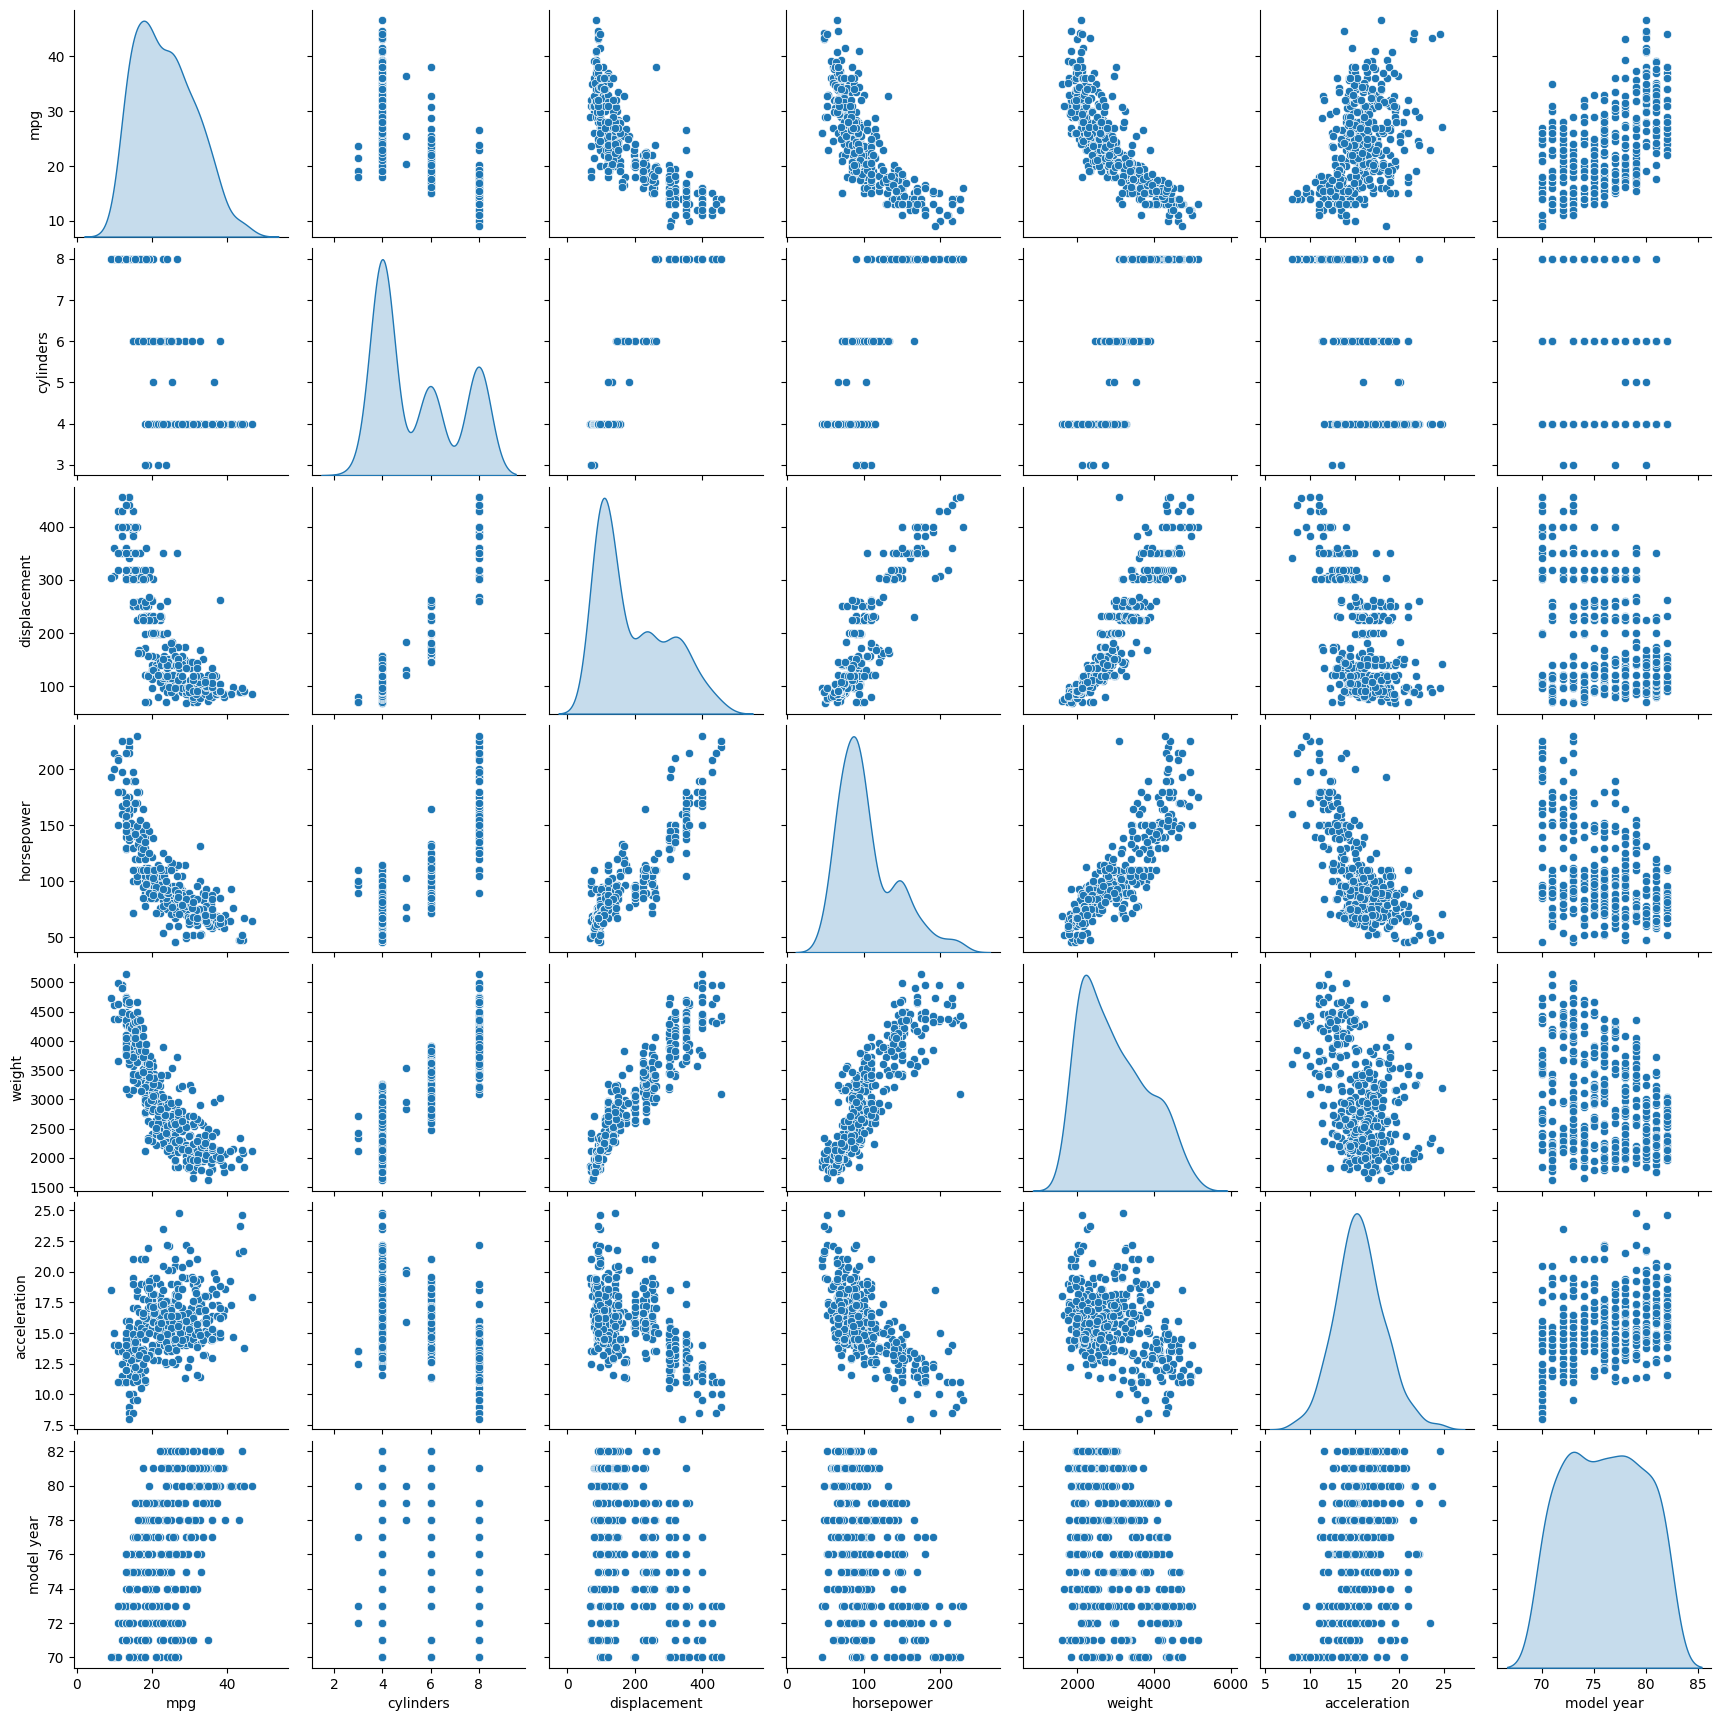

In [ ]:
cData_attr = cData.iloc[:, 0:7]
sns.pairplot(cData_attr, diag_kind='kde')   # to plot density curve instead of histogram on the diag

Observation between 'mpg' and other attributes indicate the relationship is not really linear. However, the plots also indicate that linearity would still capture quite a bit of useful information/pattern. Several assumptions of classical linear regression seem to be violated, including the assumption of no Heteroscedasticity


## Split Data

In [43]:
cData

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin_america,origin_asia,origin_europe
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,0,0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1,0,0
394,44.0,4,97.0,52.0,2130,24.6,82,0,0,1
395,32.0,4,135.0,84.0,2295,11.6,82,1,0,0
396,28.0,4,120.0,79.0,2625,18.6,82,1,0,0


In [44]:
# lets build our linear model
# independant variables
X = cData.drop(['mpg','origin_europe'], axis=1)
# the dependent variable
y = cData[['mpg']]

In [46]:
# Split X and y into training and test set in 70:30 ratio

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)


## Fit Linear Model

In [47]:
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

We create a linear regression model and train (fit) it on the training data (`X_train`, `y_train`) to learn the relationship between the independent variables and the dependent variable.


Here are the coefficients for each variable and the intercept

In [49]:
regression_model.coef_

array([[-0.39480797,  0.02894551, -0.02175221, -0.00735203,  0.06191937,
         0.83693389, -3.001283  , -0.60601796]])

In [48]:
for idx, col_name in enumerate(X_train.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[0][idx]))

The coefficient for cylinders is -0.39480796616482383
The coefficient for displacement is 0.02894551076548718
The coefficient for horsepower is -0.021752207723546777
The coefficient for weight is -0.007352032065147351
The coefficient for acceleration is 0.061919366007618756
The coefficient for model year is 0.836933891764499
The coefficient for origin_america is -3.001283000918514
The coefficient for origin_asia is -0.6060179643247368


In [50]:
intercept = regression_model.intercept_[0]
print("The intercept for our model is {}".format(intercept))

The intercept for our model is -18.283451116372046


The score (R^2) for in-sample and out of sample

In [51]:
regression_model.score(X_train, y_train)

0.8141025501610559

In [52]:
#out of sample score (R^2)

regression_model.score(X_test, y_test)


0.8433135132808833

## Adding interaction terms


`PolynomialFeatures` is a preprocessing technique used to **add polynomial terms** to your input features, allowing linear models to capture **non-linear relationships** between variables.

In [53]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

poly = PolynomialFeatures(degree=2, interaction_only=True)
X_train2 = poly.fit_transform(X_train)
X_test2 = poly.fit_transform(X_test)

poly_clf = linear_model.LinearRegression()

poly_clf.fit(X_train2, y_train)

y_pred = poly_clf.predict(X_test2)

#print(y_pred)

#In sample (training) R^2 will always improve with the number of variables!
print(poly_clf.score(X_train2, y_train))

0.9026446935642735


In the above code, we
- first use `PolynomialFeatures` to create interaction terms (without powers)
- then train a linear regression model on the transformed features.
  - This captures interactions between variables.
- print the R² score on the training set
    - This score usually increases with more features, though it may not always generalize well to new data.


In [54]:
#Out off sample (testing) R^2 is our measure of sucess and does improve
print(poly_clf.score(X_test2, y_test))

0.8668600517980215


In [56]:
# but this improves as the cost of 29 extra variables!
print(X_train.shape)
print(X_train2.shape)

(278, 8)
(278, 37)


Polynomial Features (with only interaction terms) have improved the Out of sample R^2. However at the cost of increasing the number of variables significantly.
